In [3]:
import torch
torch.__version__
# reasoning_from_scratch.__version__

'2.10.0'

In [5]:
import torch
 
print(f"PyTorch version {torch.__version__}")
if torch.cuda.is_available():
    print("CUDA GPU")
elif torch.mps.is_available():
    print("Apple Silicon GPU")
else:
    print("Only CPU")

PyTorch version 2.10.0
Apple Silicon GPU


## Download Tokenizer Files

In [6]:
from reasoning_from_scratch.qwen3 import download_qwen3_small
download_qwen3_small(kind="base", tokenizer_only=True, out_dir="qwen3")

## load the tokenizer settings from the tokenizer file into the Qwen3Tokenizer

In [9]:
from pathlib import Path
from reasoning_from_scratch.qwen3 import Qwen3Tokenizer
 
tokenizer_path = Path("qwen3") / "tokenizer-base.json"
tokenizer = Qwen3Tokenizer(tokenizer_file_path=tokenizer_path)

In [8]:
prompt = "Explain large language models"
input_token_ids_list = tokenizer.encode(prompt)

In [6]:
input_token_ids_list

[840, 20772, 3460, 4128, 4119]

In [7]:
text = tokenizer.decode(input_token_ids_list)
print(text)

Explain large language models


In [8]:
for i in input_token_ids_list:
    print(f"{[i]} --> {tokenizer.decode([i])}")

[840] --> Ex
[20772] --> plain
[3460] -->  large
[4128] -->  language
[4119] -->  models


In [12]:
def get_device(enable_tensor_cores=True):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using NVIDIA CUDA GPU")
        
        if enable_tensor_cores:
            major, minor = map(int, torch.__version__.split(".")[:2])
            if (major, minor) >= (2, 9):
                torch.backends.cuda.matmul.fp32_precision = "tf32"
                torch.backends.cudnn.conv.fp32_precision = "tf32"
            else:
                torch.backends.cuda.matmul.allow_tf32 = True
                torch.backends.cudnn.allow_tf32 = True
 
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using Apple Silicon GPU (MPS)")
 
    elif torch.xpu.is_available():
        device = torch.device("xpu")
        print("Using Intel GPU")
 
    else:
        device = torch.device("cpu")
        print("Using CPU")
 
    return device

In [13]:
device = get_device()
device

Using Apple Silicon GPU (MPS)


device(type='mps')

In [11]:
download_qwen3_small(kind="base", tokenizer_only=False, out_dir="qwen3")

✓ qwen3/qwen3-0.6B-base.pth already up-to-date


In [15]:
from reasoning_from_scratch.qwen3 import Qwen3Model, QWEN_CONFIG_06_B
 
model_path = Path("qwen3") / "qwen3-0.6B-base.pth"
model = Qwen3Model(QWEN_CONFIG_06_B)
model.load_state_dict(torch.load(model_path))
model.to(device)

Qwen3Model(
  (tok_emb): Embedding(151936, 1024)
  (trf_blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=1024, out_features=2048, bias=False)
        (W_key): Linear(in_features=1024, out_features=1024, bias=False)
        (W_value): Linear(in_features=1024, out_features=1024, bias=False)
        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): RMSNorm()
        (k_norm): RMSNorm()
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=1024, out_features=3072, bias=False)
        (fc2): Linear(in_features=1024, out_features=3072, bias=False)
        (fc3): Linear(in_features=3072, out_features=1024, bias=False)
      )
      (norm1): RMSNorm()
      (norm2): RMSNorm()
    )
  )
  (final_norm): RMSNorm()
  (out_head): Linear(in_features=1024, out_features=151936, bias=False)
)

In [16]:
prompt = "Explain large language models."
input_token_ids_list = tokenizer.encode(prompt)
print(f"Number of input tokens: {len(input_token_ids_list)}")
 
input_tensor = torch.tensor(input_token_ids_list)
input_tensor_fmt = input_tensor.unsqueeze(0)
input_tensor_fmt = input_tensor_fmt.to(device)
 
output_tensor = model(input_tensor_fmt)
output_tensor_fmt = output_tensor.squeeze(0)
print(f"Formatted Output tensor shape: {output_tensor_fmt.shape}")

Number of input tokens: 6
Formatted Output tensor shape: torch.Size([6, 151936])


In [14]:
example = torch.tensor([1, 2, 3]) 
print(example)
print(example.unsqueeze(0))

tensor([1, 2, 3])
tensor([[1, 2, 3]])


In [15]:
example = torch.tensor([[1, 2, 3]]) 
print(example)
print(example.squeeze(0))

tensor([[1, 2, 3]])
tensor([1, 2, 3])


In [16]:
last_token = output_tensor_fmt[-1].detach()
print(last_token)

tensor([ 7.3438,  2.0312,  7.9375,  ..., -2.5156, -2.5156, -2.5156],
       device='mps:0', dtype=torch.bfloat16)


In [17]:
# To obtain the position with the largest value score (value) in this tensor:
print(last_token.argmax(dim=-1, keepdim=True))

tensor([20286], device='mps:0')


In [18]:
print(tokenizer.decode([20286]))

 Large


In [21]:
example = torch.tensor([-2, 1, 3, 1, 5])
print(torch.max(example))
print(torch.argmax(example))
print(torch.argmax(example, keepdim=True))

tensor(5)
tensor(4)
tensor([4])


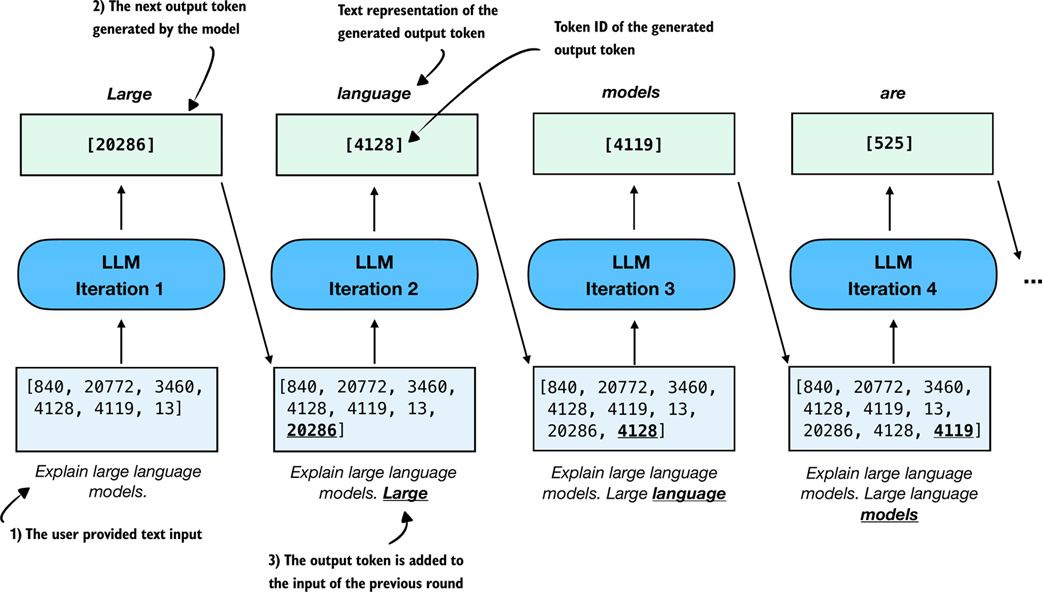

In [18]:
# Disable gradient tracking for speed and memory efficiency
@torch.inference_mode()
def generate_text_basic(model, token_ids, max_new_tokens, eos_token_id):
    input_length = token_ids.shape[1]
    # Switch model to evaluation mode to enable deterministic behavior (best practice)
    model.eval()
 
    for _ in range(max_new_tokens):
        out = model(token_ids)[:, -1]
        next_token = torch.argmax(out, dim=-1, keepdim=True)
 
        if (eos_token_id is not None
                and next_token.item() == eos_token_id):
            break

        # concatenating new token at the end of prev. tokens
        token_ids = torch.cat(
            [token_ids, next_token], dim=1)
    
    # Slicing off the original prompt    
    return token_ids[:, input_length:]

def generate_text_basic_stream(model, token_ids, max_new_tokens, eos_token_id=tokenizer.eos_token_id):
    # input_length = token_ids.shape[1]
    model.eval()
 
    for _ in range(max_new_tokens):
        out = model(token_ids)[:, -1]
        next_token = torch.argmax(out, dim=-1, keepdim=True)
 
        if (eos_token_id is not None
                and next_token.item() == eos_token_id):
            break

        yield next_token
 
        token_ids = torch.cat(
            [token_ids, next_token], dim=1)
 

In [19]:
prompt = "Explain large language models in a single sentence."
input_token_ids_tensor = torch.tensor(
    tokenizer.encode(prompt),
    device=device
    ).unsqueeze(0)
 
max_new_tokens = 100
output_token_ids_tensor = generate_text_basic(
    model=model,
    token_ids=input_token_ids_tensor,
    max_new_tokens=max_new_tokens,
    eos_token_id=tokenizer.eos_token_id
)

output_text = tokenizer.decode(
    output_token_ids_tensor.squeeze(0).tolist()
)
print(output_text.lstrip())

Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing articles, and even creating creative content.


In [32]:
print(tokenizer.encode("<|endoftext|>"))

[151643]


In [22]:
# using Streaming
for token in generate_text_basic_stream(
    model=model,
    token_ids=input_token_ids_tensor,
    max_new_tokens=50,
    eos_token_id=tokenizer.eos_token_id
):
    token_id = token.squeeze(0).tolist()
    print(
        tokenizer.decode(token_id),
        end="",
        flush=True
    )

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing articles, and even creating creative content.

In [23]:
def generate_stats(output_token_ids, tokenizer, start_time,
                   end_time, print_tokens=True):
    total_time = end_time - start_time
    print(f"Time: {total_time:.2f} sec")
    print(f"{int(output_token_ids.numel() / total_time)} tokens/sec")
 
    for name, backend in (("CUDA", getattr(torch, "cuda", None)),
                          ("XPU", getattr(torch, "xpu", None))):
        if backend is not None and backend.is_available():
            max_mem_bytes = backend.max_memory_allocated()
            max_mem_gb = max_mem_bytes / (1024 ** 3)
            print(f"Max {name} memory allocated: {max_mem_gb:.2f} GB")
            backend.reset_peak_memory_stats()
 
    if print_tokens:
        output_text = tokenizer.decode(output_token_ids.squeeze(0).tolist())
        print(f"\n{output_text}")

In [25]:
import time
prompt = "Explain large language models in a single sentence."
input_token_ids_tensor = torch.tensor(
    tokenizer.encode(prompt),
    device=device
    ).unsqueeze(0)
 
max_new_tokens = 100
start_time = time.time()
output_token_ids_tensor = generate_text_basic(
    model=model,
    token_ids=input_token_ids_tensor,
    max_new_tokens=max_new_tokens,
    eos_token_id=tokenizer.eos_token_id
)
end_time = time.time()
generate_stats(input_token_ids_tensor, tokenizer, start_time, end_time)
output_text = tokenizer.decode(
    output_token_ids_tensor.squeeze(0).tolist()
)
print(output_text)

Time: 2.42 sec
4 tokens/sec

Explain large language models in a single sentence.
 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing articles, and even creating creative content.


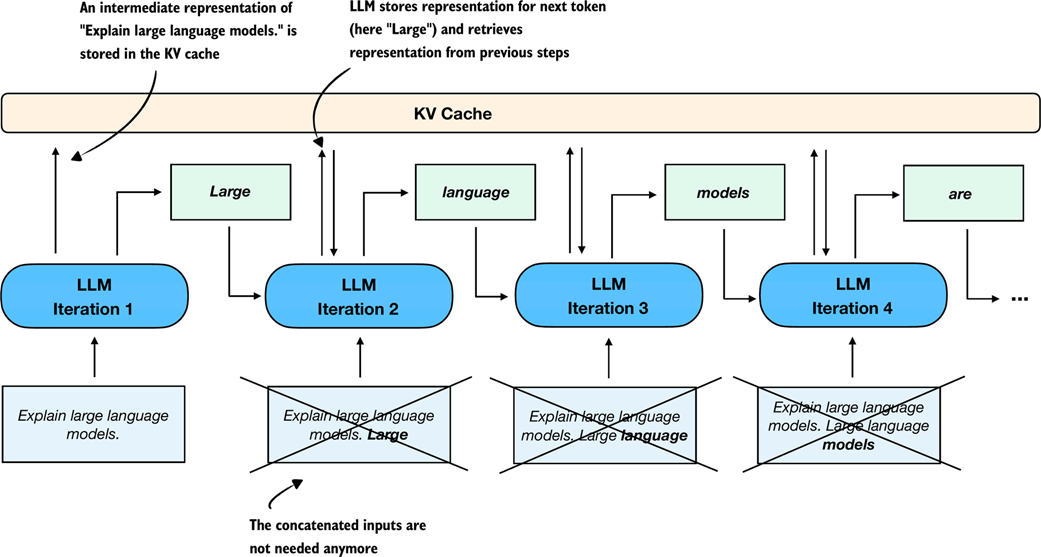]

In [26]:
# implement KV caching
from reasoning_from_scratch.qwen3 import KVCache
 
@torch.inference_mode()
def generate_text_basic_cache(
    model,
    token_ids,
    max_new_tokens,
    eos_token_id=None
):
 
    input_length = token_ids.shape[1]
    model.eval()
    # initialize KV cache
    cache = KVCache(n_layers=model.cfg["n_layers"])
    model.reset_kv_cache()
    # initially full input is provided to the model
    out = model(token_ids, cache=cache)[:, -1]
 
    for _ in range(max_new_tokens):
        next_token = torch.argmax(out, dim=-1, keepdim=True)
 
        if (eos_token_id is not None
                and next_token.item() == eos_token_id):
            break
 
        token_ids = torch.cat([token_ids, next_token], dim=1)
        # subsequent iterations only feel next_token to the model
        out = model(next_token, cache=cache)[:, -1]
 
    return token_ids[:, input_length:]
 

In [27]:
start_time = time.time()
output_token_ids_tensor = generate_text_basic_cache(
    model=model,
    token_ids=input_token_ids_tensor,
    max_new_tokens=max_new_tokens,
    eos_token_id=tokenizer
        .eos_token_id,
)
end_time = time.time()
generate_stats(output_token_ids_tensor, tokenizer, start_time, end_time)

Time: 1.93 sec
18 tokens/sec

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform tasks such as answering questions, writing text, and even creating music.


## Compiling model ahead of time using PyTorch

In [29]:
major, minor = map(int, torch.__version__.split(".")[:2])
if (major, minor) >= (2, 8):
    # This avoids retriggering model recompilations 
    # in PyTorch 2.8 and newer
    # if the model contains code like self.pos = self.pos + 1
    torch._dynamo.config.allow_unspec_int_on_nn_module = True
 
model_compiled = torch.compile(model, mode="max-autotune")

In [28]:
torch.__version__

'2.10.0'

In [31]:
# Eval - Basic text Generation using Compiled Model
for i in range(5):
    start_time = time.time()
    output_token_ids_tensor = generate_text_basic(
        model=model_compiled,
        token_ids=input_token_ids_tensor,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id
    )
    end_time = time.time()
 
    if i == 0:
        print("Warm-up run")
    else:
        print(f"Timed run {i}:")
    generate_stats(output_token_ids_tensor, tokenizer, start_time, end_time)
 
    print(f"\n{30*'-'}\n")

Warm-up run
Time: 1.64 sec
24 tokens/sec

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing essays, and even creating creative content.

------------------------------

Timed run 1:
Time: 1.39 sec
29 tokens/sec

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing essays, and even creating creative content.

------------------------------

Timed run 2:
Time: 1.55 sec
26 tokens/sec

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing essays, and even creating creative content.

------------------------------

Timed run 3:
Time: 1.57 sec
26 toke

In [32]:
# Eval - Text Generation with KV Caching using Compiled Model
for i in range(3):
    start_time = time.time()
    output_token_ids_tensor = generate_text_basic_cache(
        model=model_compiled,
        token_ids=input_token_ids_tensor,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id
    )
    end_time = time.time()
 
    if i == 0:
        print("Warm-up run")
        generate_stats(
        output_token_ids_tensor, tokenizer, start_time, end_time
    )
    else:
        print(f"Timed run {i}:")
        generate_stats(output_token_ids_tensor, tokenizer, start_time, end_time)
 
    print(f"\n{30*'-'}\n")
 

Warm-up run
Time: 36.19 sec
1 tokens/sec

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing articles, and even creating creative content.

------------------------------

Timed run 1:
Time: 0.91 sec
45 tokens/sec

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing articles, and even creating creative content.

------------------------------

Timed run 2:
Time: 0.91 sec
45 tokens/sec

 Large language models are artificial intelligence systems that can understand, generate, and process human language, enabling them to perform a wide range of tasks, from answering questions to writing articles, and even creating creative content.

------------------------------

